In [76]:
import torch
import os
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 18, 10
register_matplotlib_converters()

In [77]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,156739,156739,156812,156864,156896,156911,157015,157032,157144,157171,157190,157218,157260,157289,157359,157387,157412,157431,157454,157499,157508,157542,157585,157603,157611,157633,157648,157660,157665,157725,157734,157745,157787,157797,157816,157841,157878,157887,157895,157951
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,194472,195021,195523,195988,195988,196611,197167,197776,198292,198732,199137,199555,199750,199945,200173,200639,201045,201402,201730,201902,202295,202641,202863,203215,203524,203787,203925,204301,204627,204928,205224,205549,205777,205897,206273,206616,206935,207221,207542,207709
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,208380,208532,208695,208839,208952,209111,209283,209463,209624,209817,209980,210152,210344,210531,210723,210921,211112,211297,211469,211662,211859,212047,212224,212434,212652,212848,213058,213288,213533,213745,214044,214330,214592,214835,215145,215430,215723,216098,216376,216637
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15972,16035,16086,16086,16086,16299,16342,16426,16566,16712,16712,16712,16712,17115,17426,17658,18010,18010,18010,18631,18815,18815,19272,19440,19440,19440,19440,20136,20136,20549,20549,20549,20549,21062,21062,21372,21571,21730,21730,21730
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64968,64985,64997,65011,65024,65033,65061,65080,65105,65130,65139,65144,65155,65168,65183,65208,65223,65244,65259,65259,65301,65332,65346,65371,65397,65404,65404,65431,65565,65648,65760,65868,65938,66086,66566,67199,68362,70221,71142,71752


In [78]:
df = df[df["Country/Region"]=="Germany"]
df = pd.DataFrame(df[df.columns[4:]].sum(),columns=["confirmed"])
df

,confirmed
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
...,...
12/22/21,6943750
12/23/21,6978170
12/24/21,6982238
12/25/21,6999476


In [79]:
df.isnull().sum().sum()


0

In [80]:
df.index = pd.to_datetime(df.index,format='%m/%d/%y')
df

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-12-22,6943750
2021-12-23,6978170
2021-12-24,6982238
2021-12-25,6999476


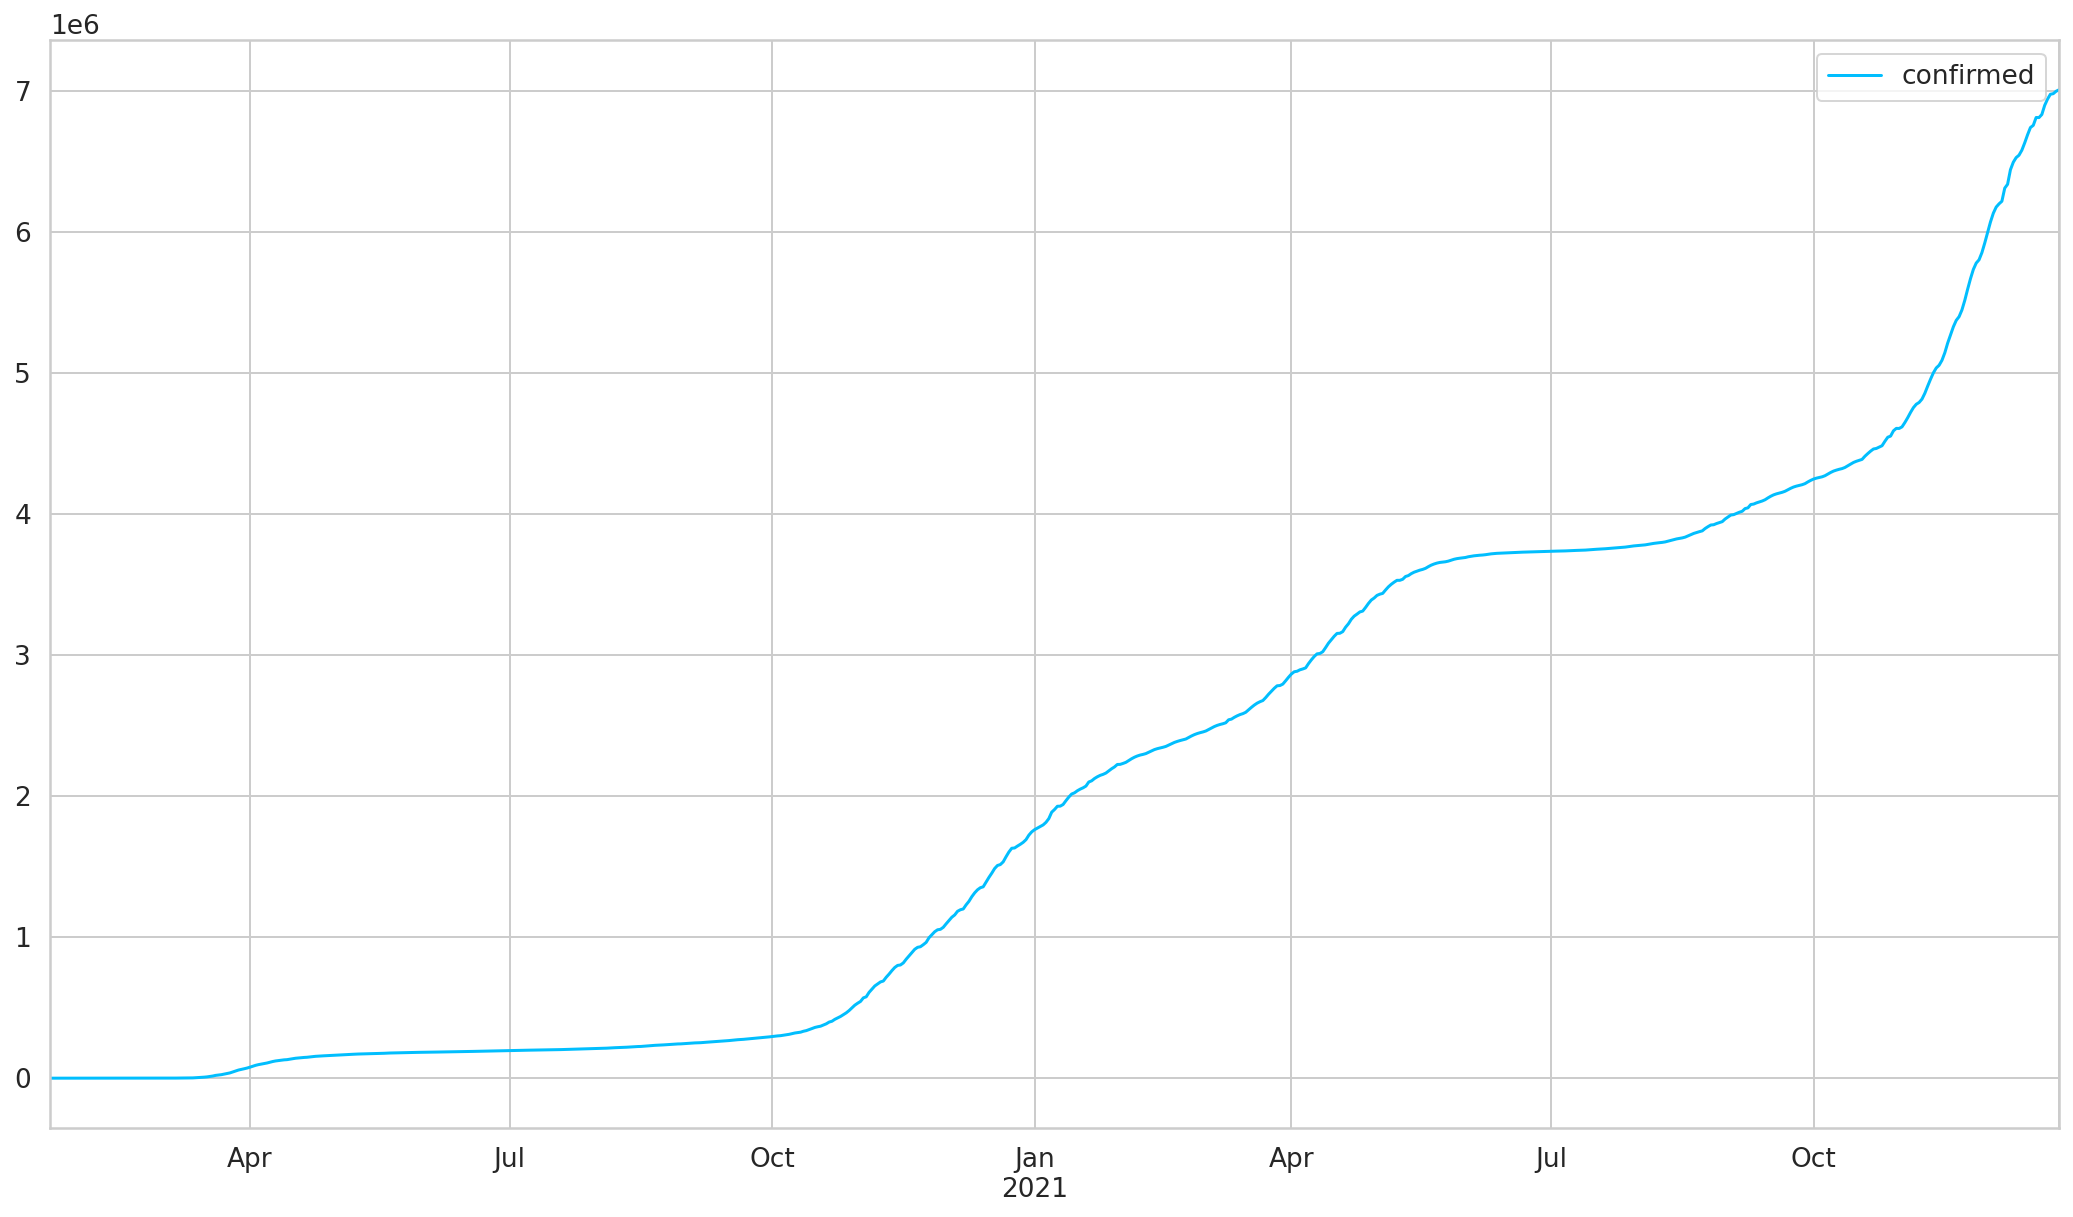

In [81]:
df.plot()

In [82]:
y = df['confirmed'].values.astype(float)

In [83]:
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil(len(y) * 0.95) 
test_data_len = len(y) - training_data_len


In [84]:
training_data_len, test_data_len

(670, 35)

In [85]:
train_set = y[:training_data_len]
test_set = y[training_data_len:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 670
Test:  35


In [86]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
print(f'First item, original: {train_set[-1]}')
print(f'First item, scaled: {train_norm[-1]}')

First item, original: 5400687.0
First item, scaled: [1.]


In [87]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1).cuda()
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [88]:
window_size = 30

train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 640


In [89]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers


        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(self.num_layers,1,self.hidden_dim),
                       torch.zeros(self.num_layers,1,self.hidden_dim))
        

    def forward(self,seq):
      lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
      pred = self.fc(lstm_out.view(len(seq),-1))
      return pred[-1]



In [90]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out = self.fc(out[:, -1, :]) 
#         return out

In [91]:
input_dim = 1
hidden_dim = 600
num_layers = 1
output_dim = 1
num_epochs = 200

In [92]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
  for seq, y_train in train_data:
    # reset the parameters and hidden states
    optimizer.zero_grad()
    model.hidden = (torch.zeros(model.num_layers,1,model.hidden_dim).cuda(),
                    torch.zeros(model.num_layers,1,model.hidden_dim).cuda())
    y_train_pred = model(seq)

    loss = criterion(y_train_pred, y_train)
    hist[t] = loss.item()
    loss.backward()
    optimizer.step()

        # print training result
  if t % 10 == 0 and t !=0:
    print(f'Epoch: {t+1:2} Loss: {loss.item():10.8f}')
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch: 11 Loss: 0.00038382
Epoch: 21 Loss: 0.04899992
Epoch: 31 Loss: 0.00002231
Epoch: 41 Loss: 0.00080056
Epoch: 51 Loss: 0.00048778
Epoch: 61 Loss: 0.00043134
Epoch: 71 Loss: 0.00026946
Epoch: 81 Loss: 0.00038930
Epoch: 91 Loss: 0.00051506
Epoch: 101 Loss: 0.00212754
Epoch: 111 Loss: 0.00067286
Epoch: 121 Loss: 0.00017068
Epoch: 131 Loss: 0.00018623
Epoch: 141 Loss: 0.00018286
Epoch: 151 Loss: 0.00021306
Epoch: 161 Loss: 0.00015320
Epoch: 171 Loss: 0.00051827
Epoch: 181 Loss: 0.00000505
Epoch: 191 Loss: 0.00008089
Training time: 1044.1205542087555


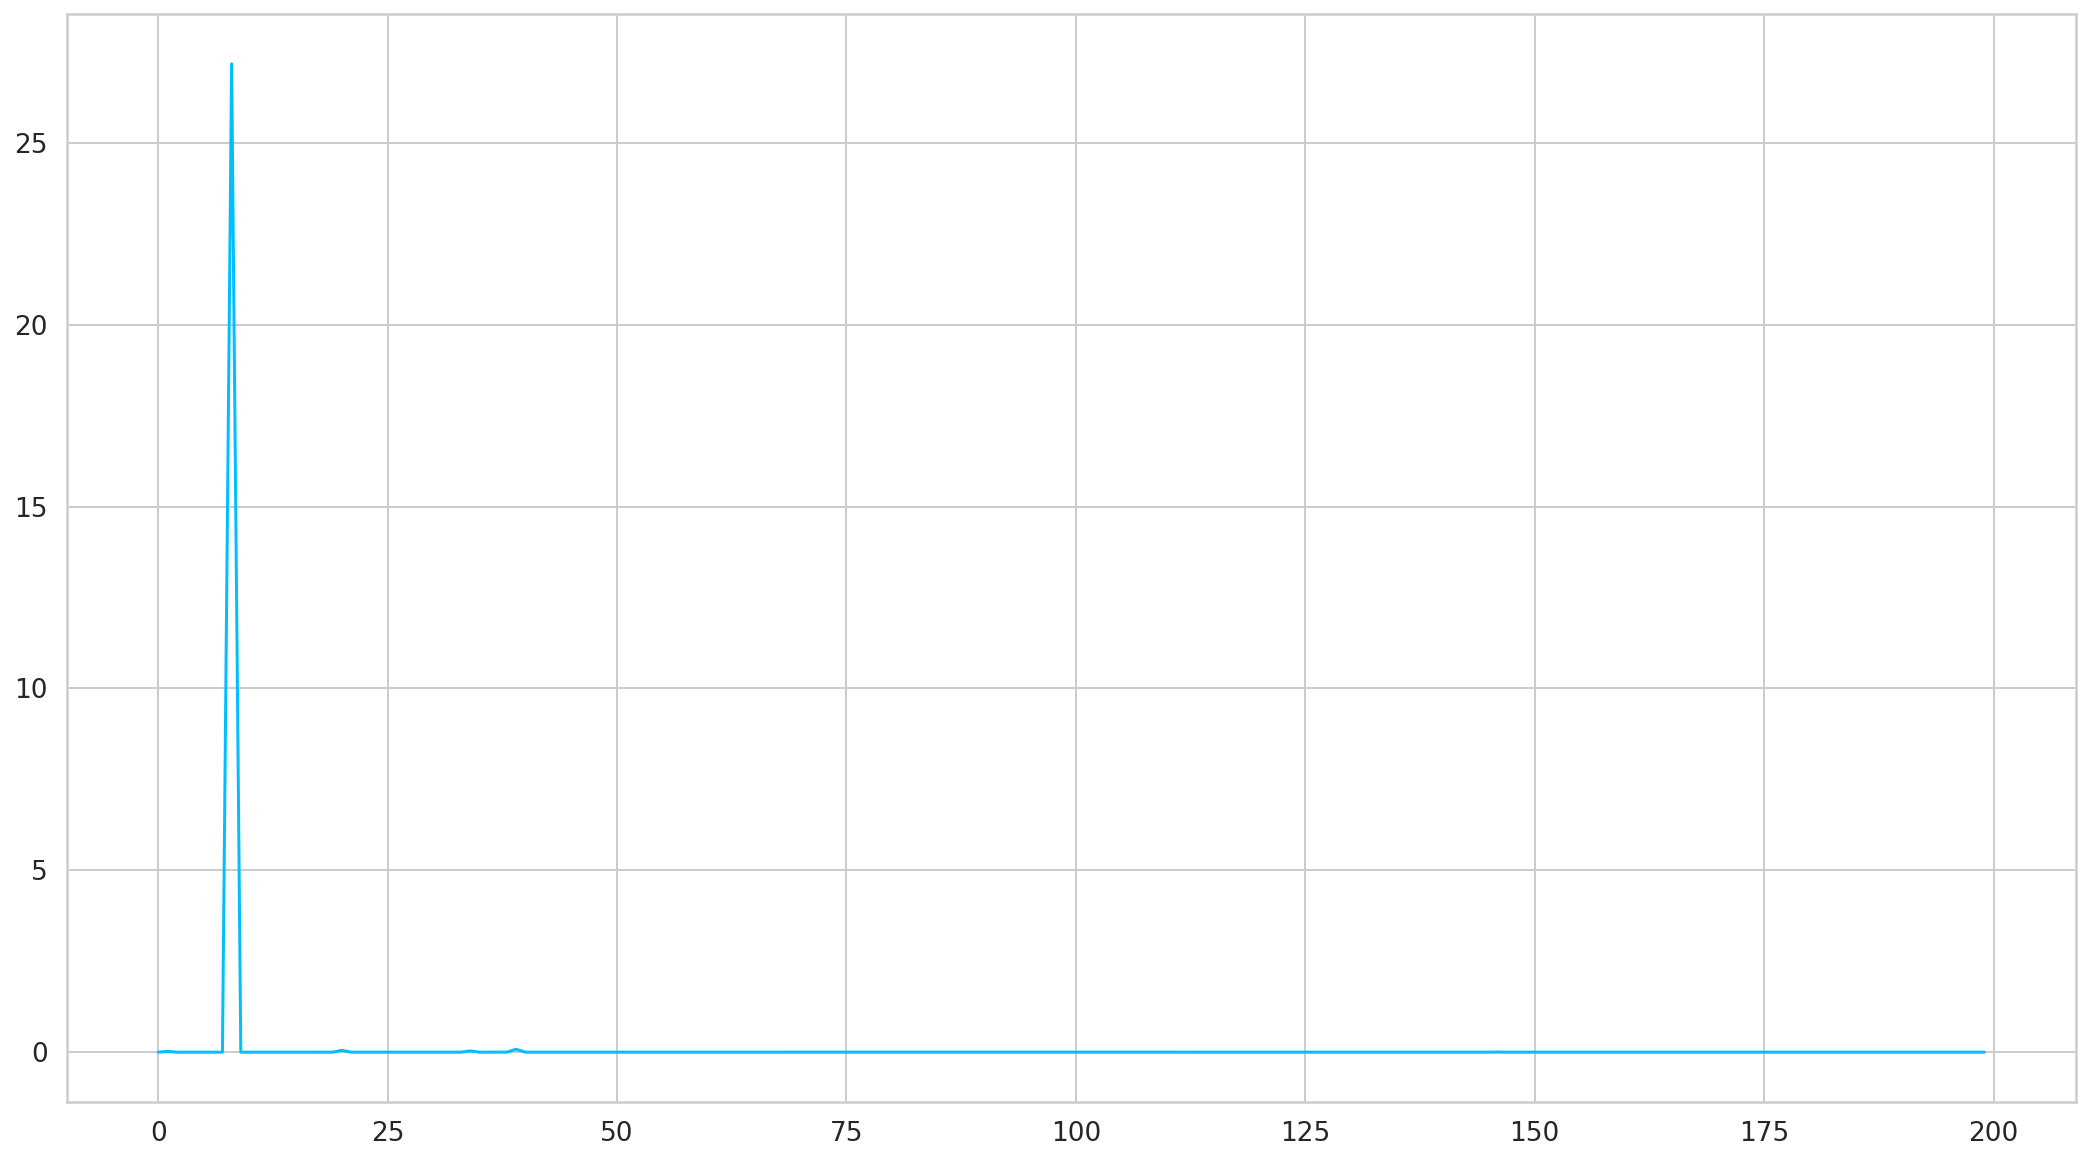

In [101]:
plt.plot(hist)


In [102]:
# DON'T WRITE HERE
future = 35
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(model.num_layers,1,model.hidden_dim).cuda(),
                        torch.zeros(model.num_layers,1,model.hidden_dim).cuda())
        preds.append(model(seq).item())
        
preds[window_size:]

[1.024852991104126,
 1.0418379306793213,
 1.057586908340454,
 1.070922613143921,
 1.082827091217041,
 1.0895066261291504,
 1.0983383655548096,
 1.1019971370697021,
 1.1066136360168457,
 1.1100077629089355,
 1.1114802360534668,
 1.1130499839782715,
 1.1130187511444092,
 1.111476182937622,
 1.1102569103240967,
 1.1074812412261963,
 1.1052229404449463,
 1.102959156036377,
 1.1000399589538574,
 1.0975840091705322,
 1.0944299697875977,
 1.09098219871521,
 1.0877315998077393,
 1.0845947265625,
 1.0822393894195557,
 1.0811429023742676,
 1.0799834728240967,
 1.079451322555542,
 1.0785565376281738,
 1.0774908065795898,
 1.0771815776824951,
 1.0768725872039795,
 1.0767467021942139,
 1.0768234729766846,
 1.0766634941101074]

In [103]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions = true_predictions.astype(int)
true_predictions

array([[5467798],
       [5513663],
       [5556191],
       [5592202],
       [5624348],
       [5642385],
       [5666234],
       [5676114],
       [5688580],
       [5697745],
       [5701721],
       [5705960],
       [5705876],
       [5701710],
       [5698418],
       [5690923],
       [5684825],
       [5678712],
       [5670829],
       [5664197],
       [5655680],
       [5646370],
       [5637592],
       [5629121],
       [5622761],
       [5619800],
       [5616669],
       [5615232],
       [5612816],
       [5609938],
       [5609103],
       [5608269],
       [5607929],
       [5608136],
       [5607704]])

In [104]:
test_set = test_set.reshape(-1,1)
test_set

array([[5448574.],
       [5516623.],
       [5595674.],
       [5670253.],
       [5735837.],
       [5780814.],
       [5804139.],
       [5854884.],
       [5923564.],
       [5999020.],
       [6072299.],
       [6134492.],
       [6177992.],
       [6200937.],
       [6219259.],
       [6312346.],
       [6339828.],
       [6442846.],
       [6496142.],
       [6528894.],
       [6546010.],
       [6581433.],
       [6633666.],
       [6690568.],
       [6741968.],
       [6757684.],
       [6813287.],
       [6812746.],
       [6834488.],
       [6899437.],
       [6943750.],
       [6978170.],
       [6982238.],
       [6999476.],
       [7009648.]])

In [105]:
test = df[training_data_len:]
test["predicted"] = true_predictions
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,confirmed,predicted
2021-11-22,5448574,5467798
2021-11-23,5516623,5513663
2021-11-24,5595674,5556191
2021-11-25,5670253,5592202
2021-11-26,5735837,5624348
2021-11-27,5780814,5642385
2021-11-28,5804139,5666234
2021-11-29,5854884,5676114
2021-11-30,5923564,5688580
2021-12-01,5999020,5697745


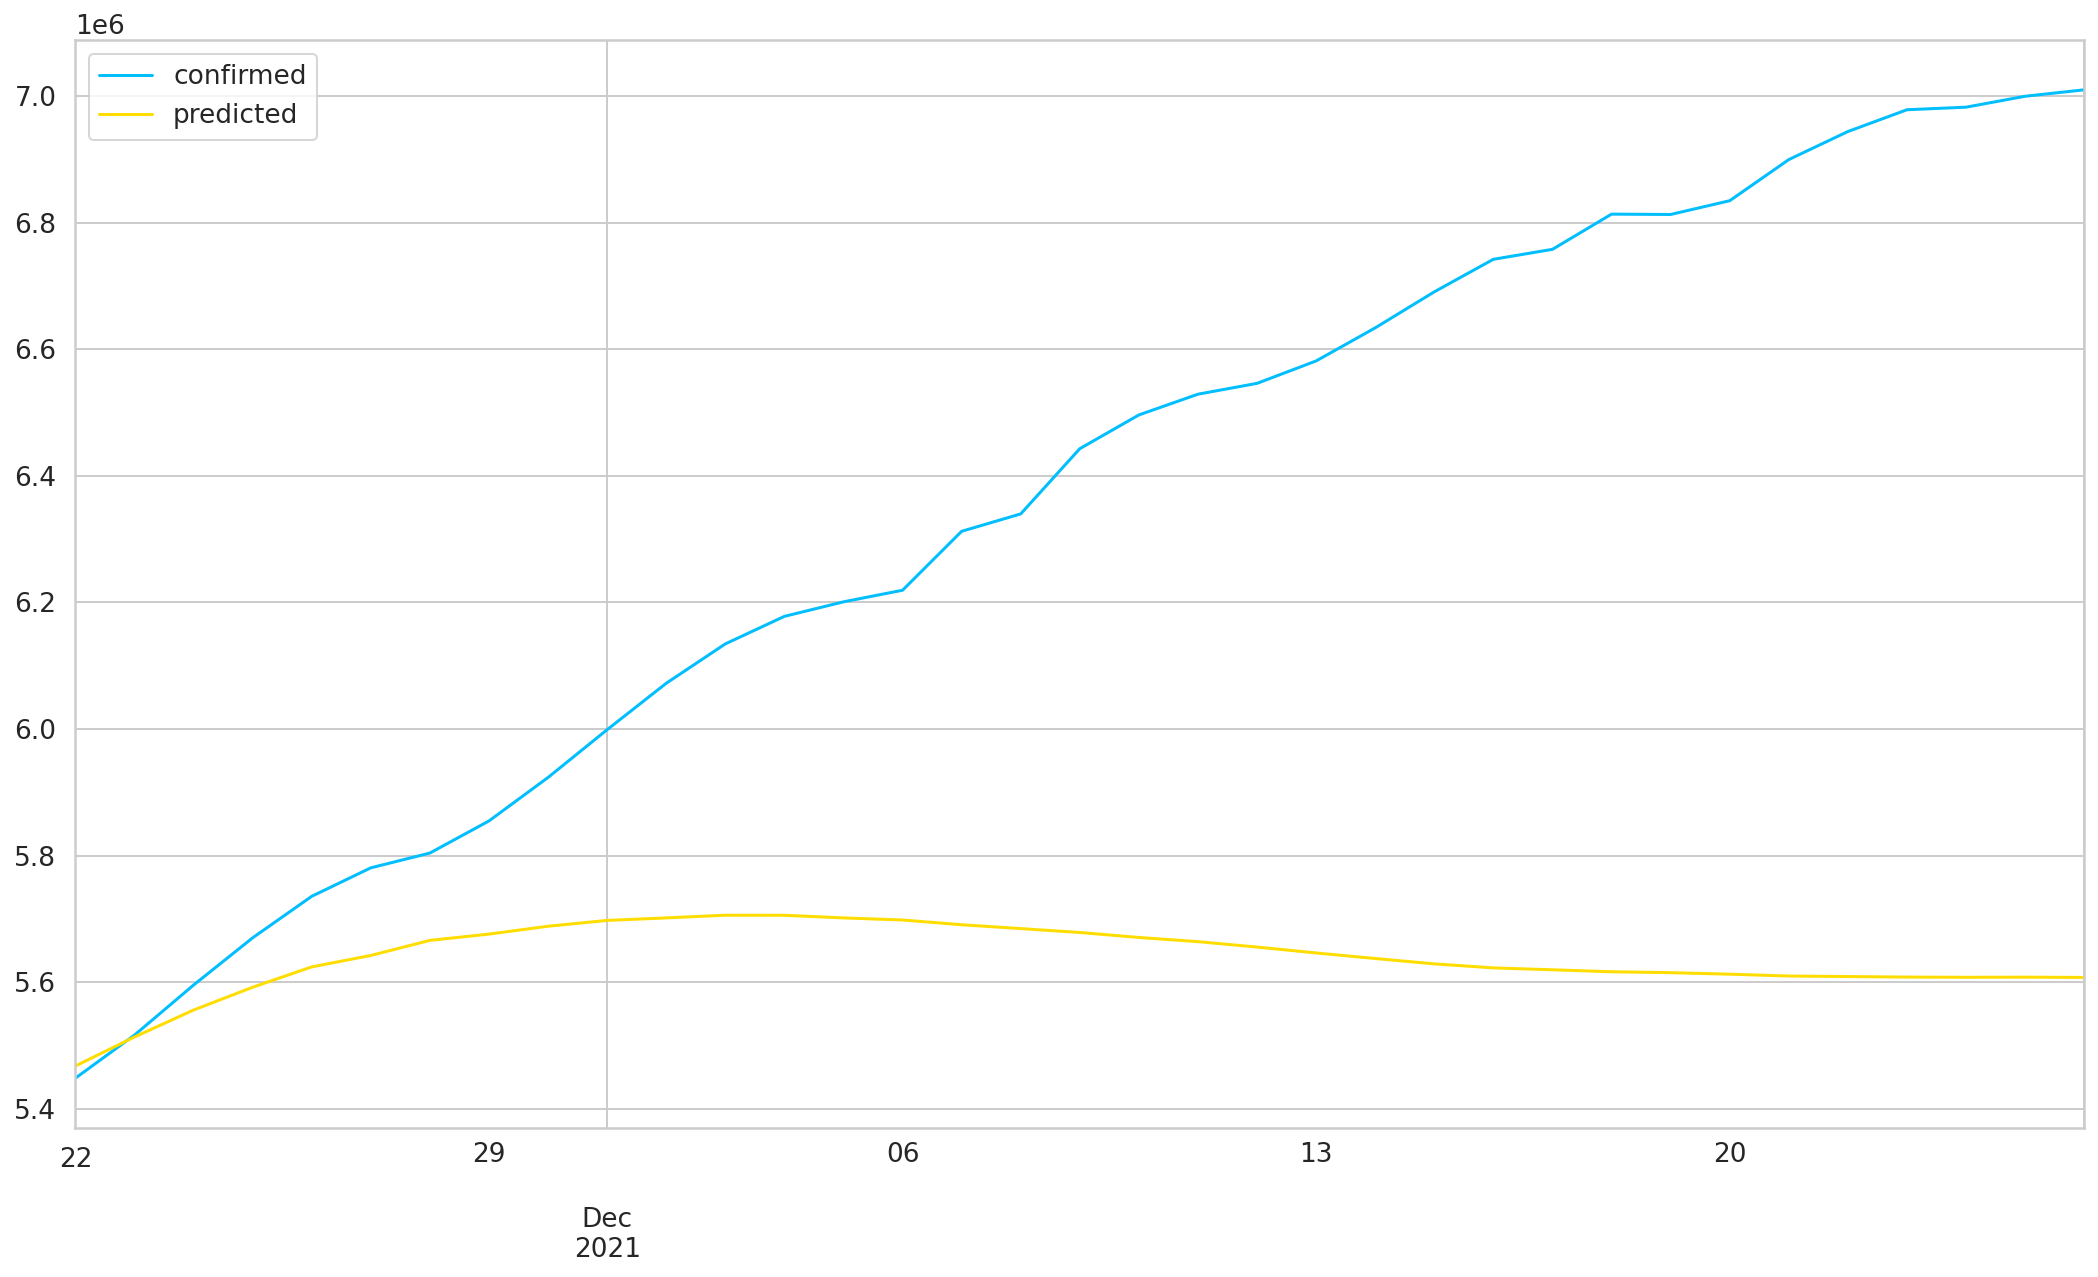

In [106]:
test.plot()

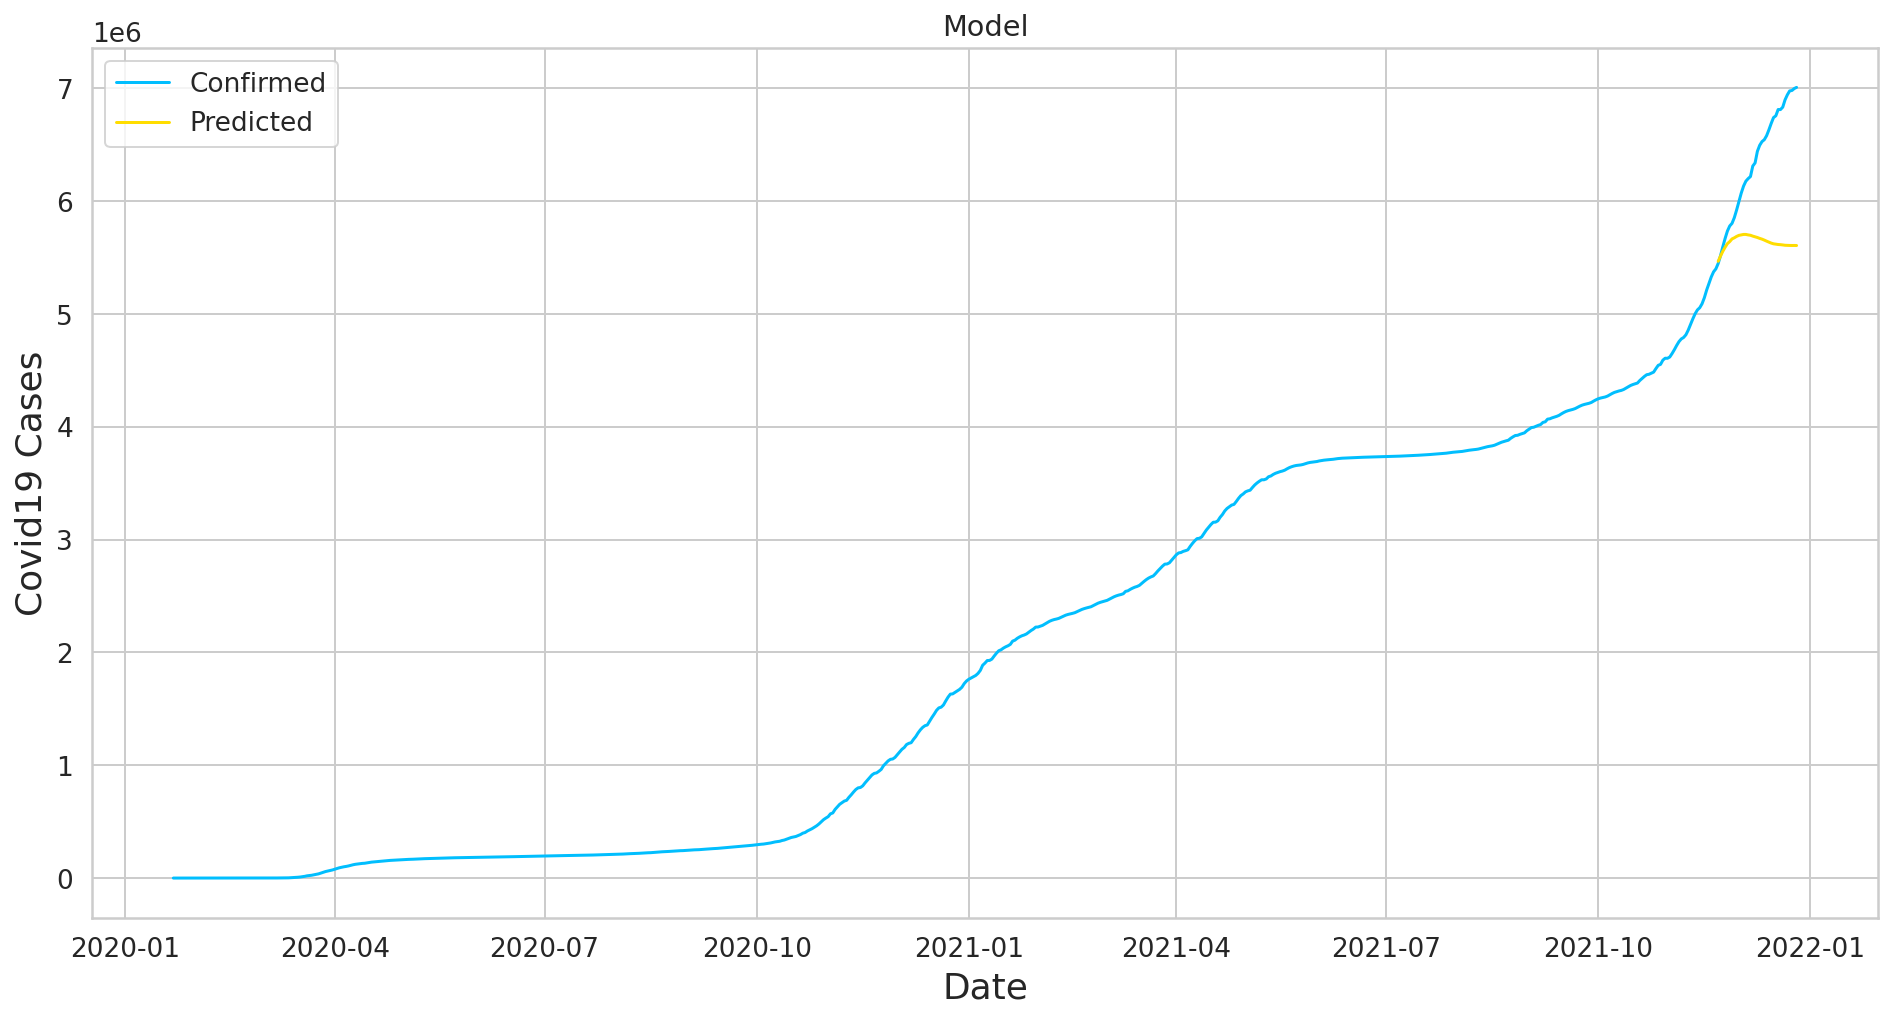

In [108]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Covid19 Cases', fontsize=18)
plt.plot(df["confirmed"], label="Confirmed")
plt.plot(test["predicted"], label="Predicted")
plt.legend()
plt.show()

In [109]:
import math
from sklearn.metrics import mean_squared_error

testScore = math.sqrt(mean_squared_error(test_set.reshape(-1,1), true_predictions.reshape(-1,1)))
print('Test Score: %.4f RMSE' % (testScore))

Test Score: 860751.9632 RMSE
